In [32]:


# Read the CSV with proper delimiter and column names
prices_df = pd.read_csv('jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv',
                        sep=';',  # Set semicolon as delimiter
                        names=['datum_nl', 'datum_utc', 'prijs_excl_belastingen'],  # Define column names
                        skiprows=1)  # Skip the first row that contains headers



# Convert the 'datum_utc' column to datetime type
prices_df['datum_utc'] = pd.to_datetime(prices_df['datum_utc'])
# drop the 'datum_nl' column if it's not needed
# rename the 'prijs_excl_belastingen' column to 'price'
prices_df = prices_df.rename(columns={'prijs_excl_belastingen': 'price'})
# Convert price values to EUR/kWh
prices_df['price'] = prices_df['price'].str.replace(',', '.').astype(float) * 1


# Display the first few rows to verify the structure
print(prices_df.head())

              datum_nl           datum_utc   price
0  2024-01-01 00:00:00 2023-12-31 23:00:00  0.0001
1  2024-01-01 01:00:00 2024-01-01 00:00:00  0.0000
2  2024-01-01 02:00:00 2024-01-01 01:00:00  0.0000
3  2024-01-01 03:00:00 2024-01-01 02:00:00 -0.0000
4  2024-01-01 04:00:00 2024-01-01 03:00:00 -0.0000


In [33]:
def find_cheapest_blocks(df, start_date, horizon_days, block_sizes=[2, 3, 4]):
    # Get data for the specified time window
    end_date = start_date + pd.Timedelta(days=horizon_days)
    mask = (df['datum_utc'] >= start_date) & (df['datum_utc'] < end_date)
    window_data = df[mask]
    
    results = []
    # For each block size
    for block_size in block_sizes:
        # Calculate rolling mean for consecutive hours
        rolling_means = window_data['price'].rolling(window=block_size).mean()
        
        # Find the minimum rolling mean and its index
        min_mean = rolling_means.min()
        min_idx = rolling_means.idxmin()
        
        if pd.notna(min_mean):  # Check if we found a valid block
            results.append({
                'start_date': start_date,
                'horizon_days': horizon_days,
                'block_size': block_size,
                'avg_price': min_mean,
                'block_start_time': df.loc[min_idx, 'datum_utc']
            })
    
    return results

# Create analysis for all days and horizons
all_results = []
start_dates = prices_df['datum_utc'].dt.normalize().unique()

for start_date in start_dates:
    # Only process if we have enough days ahead
    last_possible_date = prices_df['datum_utc'].max() - pd.Timedelta(days=1)
    if start_date <= last_possible_date:
        for horizon in range(1, 8):  # 1 to 7 days
            results = find_cheapest_blocks(prices_df, start_date, horizon)
            all_results.extend(results)

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Display first few rows of results
print(results_df.head())

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_94475/1962965348.py:15: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  min_idx = rolling_means.idxmin()
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_94475/1962965348.py:15: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  min_idx = rolling_means.idxmin()
/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_94475/1962965348.py:15: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  min_idx = rolling_means.idxmin()


  start_date  horizon_days  block_size  avg_price    block_start_time
0 2023-12-31             2           2    -0.0000 2024-01-01 06:00:00
1 2023-12-31             2           3    -0.0000 2024-01-01 05:00:00
2 2023-12-31             2           4    -0.0000 2024-01-01 06:00:00
3 2023-12-31             3           2    -0.0000 2024-01-01 06:00:00
4 2023-12-31             3           3    -0.0000 2024-01-01 05:00:00


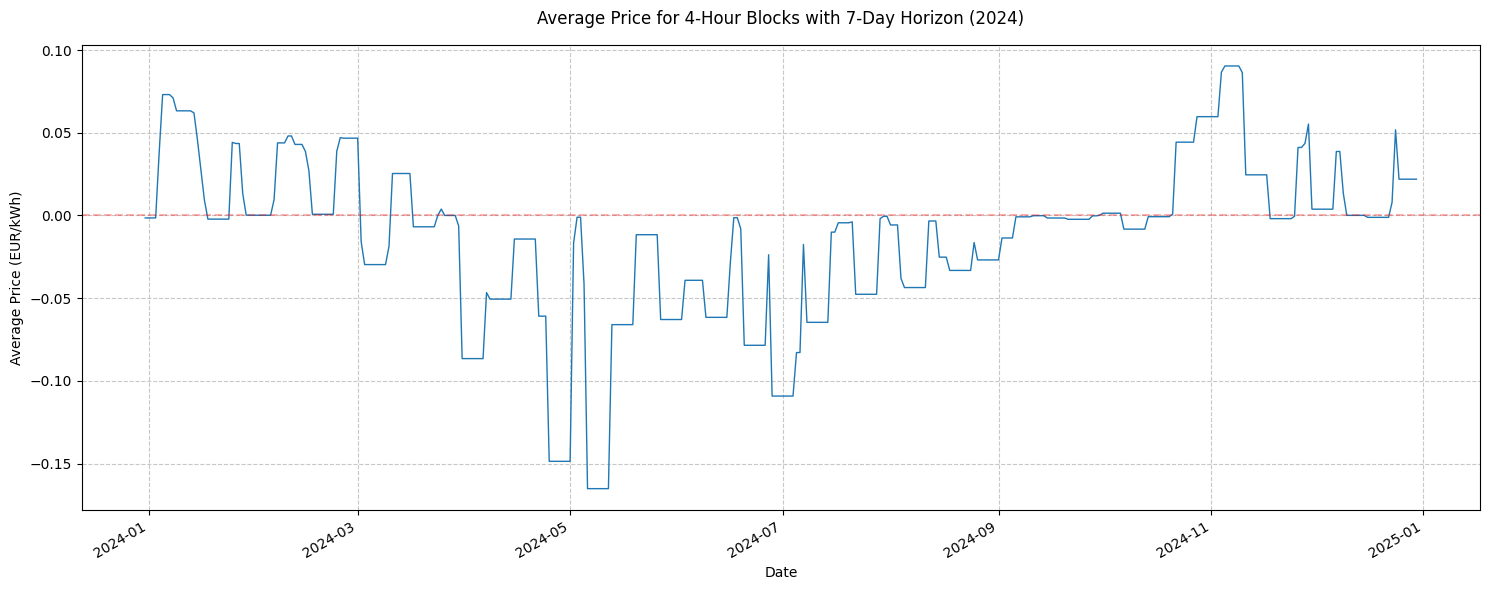

In [35]:
# Filter data for 7-day horizon and 4-hour blocks
horizon7_block4 = results_df[(results_df['horizon_days'] == 7) & (results_df['block_size'] == 4)]

# Create figure
plt.figure(figsize=(15, 6))

# Plot average price over time
plt.plot(horizon7_block4['start_date'], horizon7_block4['avg_price'], linewidth=1)

# Customize the plot
plt.title('Average Price for 4-Hour Blocks with 7-Day Horizon (2024)', pad=15)
plt.xlabel('Date')
plt.ylabel('Average Price (EUR/kWh)')
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()

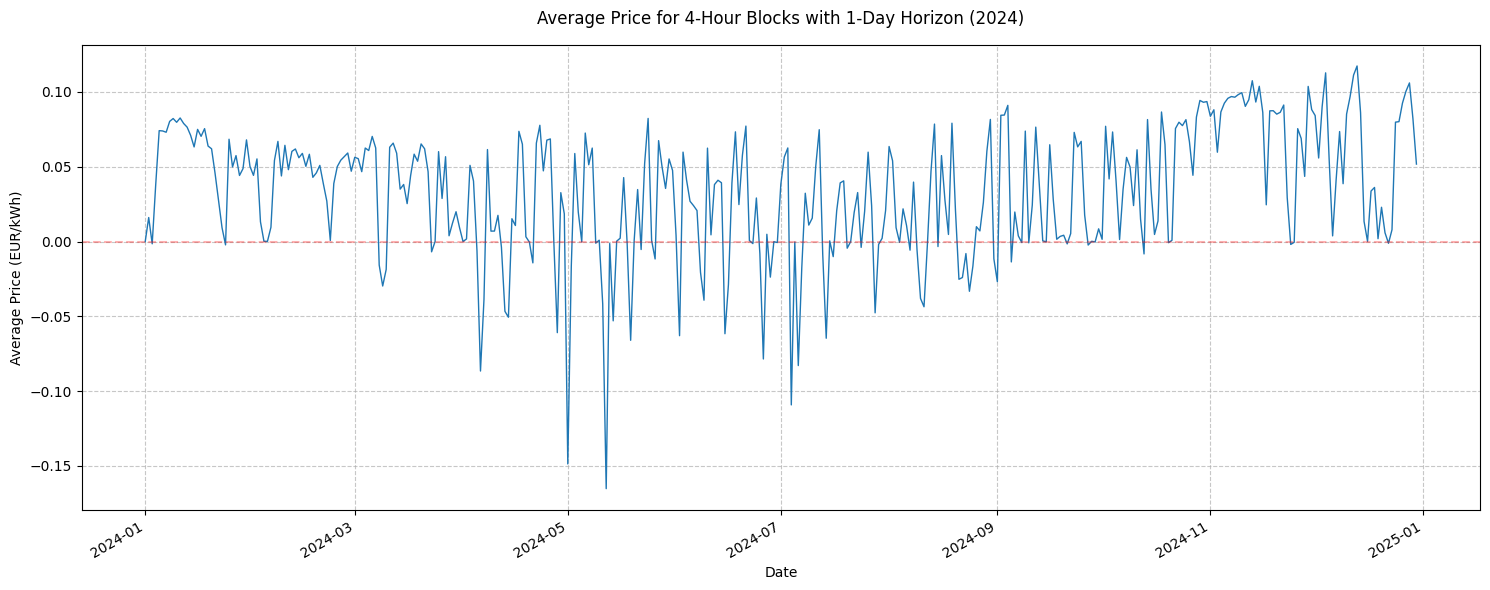

In [36]:
# Filter data for 1-day horizon and 4-hour blocks
horizon1_block4 = results_df[(results_df['horizon_days'] == 1) & (results_df['block_size'] == 4)]

# Create figure
plt.figure(figsize=(15, 6))

# Plot average price over time
plt.plot(horizon1_block4['start_date'], horizon1_block4['avg_price'], linewidth=1)

# Customize the plot
plt.title('Average Price for 4-Hour Blocks with 1-Day Horizon (2024)', pad=15)
plt.xlabel('Date')
plt.ylabel('Average Price (EUR/kWh)')
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()

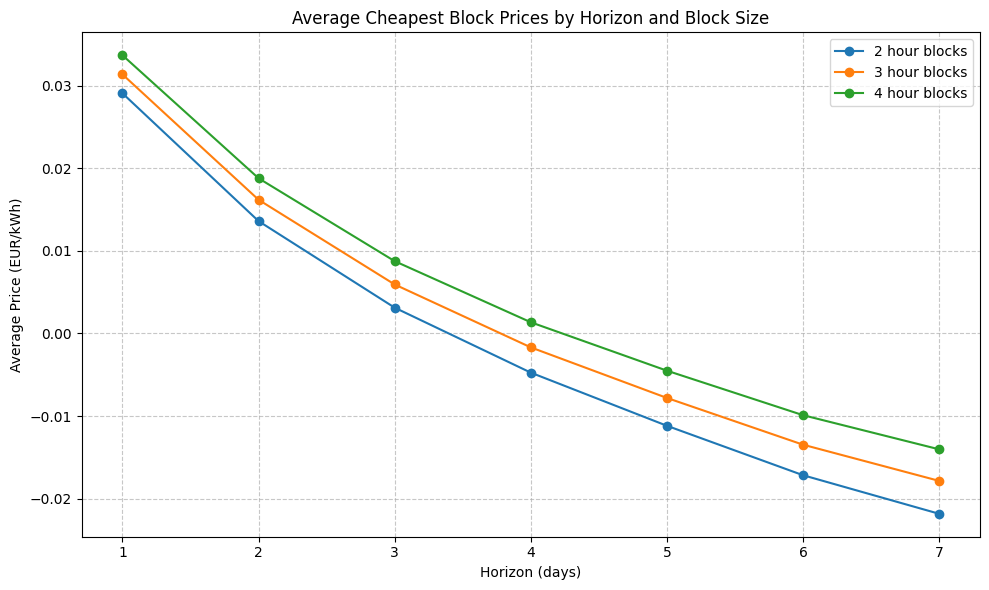

In [37]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate mean prices grouped by horizon and block size
mean_prices = results_df.groupby(['horizon_days', 'block_size'])['avg_price'].mean().reset_index()

# Create plot
plt.figure(figsize=(10, 6))

# Plot one line per block size
for block_size in [2, 3, 4]:
    data = mean_prices[mean_prices['block_size'] == block_size]
    plt.plot(data['horizon_days'], data['avg_price'], 
             marker='o', 
             label=f'{block_size} hour blocks')

plt.xlabel('Horizon (days)')
plt.ylabel('Average Price (EUR/kWh)')
plt.title('Average Cheapest Block Prices by Horizon and Block Size')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Set x-axis ticks to whole numbers
plt.xticks(range(1, 8))

plt.tight_layout()

In [38]:
# Calculate baseline prices (1 day horizon) for each block size
baseline_prices = mean_prices[mean_prices['horizon_days'] == 1].set_index('block_size')['avg_price']

# Calculate savings relative to 1 day horizon
savings_df = mean_prices.copy()
for block in [2,3,4]:
    mask = savings_df['block_size'] == block
    savings_df.loc[mask, 'savings_per_kwh'] = baseline_prices[block] - savings_df.loc[mask, 'avg_price']
    
# Calculate annual savings based on 2500 kWh usage
savings_df['annual_savings'] = savings_df['savings_per_kwh'] * 2500

# Format and display results
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
print("\nSavings analysis (negative values indicate higher costs):")
print("=====================================================")
print(savings_df[['horizon_days', 'block_size', 'savings_per_kwh', 'annual_savings']])


Savings analysis (negative values indicate higher costs):
    horizon_days  block_size  savings_per_kwh  annual_savings
0              1           2           0.0000          0.0000
1              1           3           0.0000          0.0000
2              1           4           0.0000          0.0000
3              2           2           0.0155         38.7046
4              2           3           0.0152         37.9652
5              2           4           0.0149         37.2517
6              3           2           0.0260         64.9082
7              3           3           0.0254         63.6058
8              3           4           0.0249         62.3449
9              4           2           0.0338         84.5774
10             4           3           0.0331         82.6508
11             4           4           0.0323         80.8457
12             5           2           0.0403        100.6664
13             5           3           0.0392         97.9603
14         

In [39]:
# Get the baseline price for 1 day horizon and 4 hour blocks
baseline_price = mean_prices[(mean_prices['horizon_days']==1) & (mean_prices['block_size']==4)]['avg_price'].values[0]

# Calculate annual cost
annual_cost = baseline_price * 2500

print(f"Average price per kWh: €{baseline_price:.4f}")
print(f"Annual cost for 2500 kWh: €{annual_cost:.2f}")

Average price per kWh: €0.0337
Annual cost for 2500 kWh: €84.23


In [40]:
# Base price per kWh (from baseline_price)
base_price = baseline_price

# Additional costs (example value 0.10154 EUR/kWh)
additional_costs = 0.10154

# Calculate subtotal
subtotal = base_price + additional_costs

# Add 21% VAT
total_with_vat = subtotal * 1.21

print(f"Base price per kWh: €{base_price:.4f}")
print(f"Additional costs per kWh: €{additional_costs:.4f}")
print(f"Subtotal per kWh: €{subtotal:.4f}")
print(f"Total price per kWh (incl. 21% VAT): €{total_with_vat:.4f}")

# Calculate annual cost for 2500 kWh
annual_cost_with_vat = total_with_vat * 2500
print(f"\nAnnual cost for 2500 kWh (incl. VAT): €{annual_cost_with_vat:.2f}")


Base price per kWh: €0.0337
Additional costs per kWh: €0.1015
Subtotal per kWh: €0.1352
Total price per kWh (incl. 21% VAT): €0.1636

Annual cost for 2500 kWh (incl. VAT): €409.08
